# Tutorial 3. Few-Shot Learning

## Few-shot learning task

![](figures/meta-learning.png)
(figure from https://arxiv.org/abs/1909.13579)

## Model-agnostic Meta Learning (MAML)
![](figures/maml.png)

MAML employs bilevel optimization: inner loop solves particular task, while outer loop finds initialization to be able to solve any task quickly.


In inner loop we optimize the task loss by updating the weights:
$$
\theta_i'=\theta-\alpha \nabla_\theta  \mathcal{L}_{\mathcal{T}_i }  f_\theta ).
$$
The model parameters are trained by optimizing for the performance of $f_{\theta_i'}$
with respect to $\theta$ across tasks sampled from $p(\mathcal{T})$.
More concretely, the meta-objective is as follows:
$$
\min_\theta \sum_{\mathcal{T}_i \sim p(\mathcal{T})}   \mathcal{L}_{\mathcal{T}_i }  (f_{\theta_i'})
= \sum_{\mathcal{T}_i \sim p(\mathcal{T})}  \mathcal{L}_{\mathcal{T}_i }  ( f_{\theta - \alpha \nabla_\theta \mathcal{L}_{\mathcal{T}_i } (f_\theta)})
$$

### First-order approximation
Our update can be calculated with chain rule as
$$
\frac{\partial \mathcal{L}_v}{\partial \theta} =
\frac{\partial \theta'}{\partial \theta} \cdot \frac{\partial \mathcal{L}_v}{\partial \theta'}
$$
However, $\theta'$ is defined by inner loop updates. For example, with single inner iteration
$$
\theta' = \theta - \alpha \cdot \frac{\partial \mathcal{L}_t}{\partial \theta}
$$
And then
$$
\frac{\partial \theta'}{\partial \theta} = 1 - \alpha \cdot H(\mathcal{L}_t, \theta),
$$
where $H$ is Hessian matrix. Thus, we need to calculate Hessian-vector product for full gradient in outer loop:
$$
\frac{\partial \mathcal{L}_v}{\partial \theta} = (1 - \alpha \cdot H(\mathcal{L}_t, \theta))
\frac{\partial \mathcal{L}_v}{\partial \theta'}.
$$
The situation is even worth if we make more than one inner step. However, practically it is often possible to neglect this second-order term and approximate
$$
\frac{\partial \mathcal{L}_v}{\partial \theta} \approx
\frac{\partial \mathcal{L}_v}{\partial \theta'}.
$$

### Omniglot

In [1]:
from collections import OrderedDict
from typing import Dict, Callable, Union

import torch
from torch import nn
from torch.nn import Module
from torch.nn import functional as F
from torch.optim import Optimizer
from torchmeta.datasets.helpers import omniglot
from torchmeta.utils.data import BatchMetaDataLoader
from tqdm.notebook  import tqdm

In [2]:
# code from https://github.com/oscarknagg/few-shot/blob/master/few_shot/models.py

def conv_block(in_channels: int, out_channels: int) -> nn.Module:
    """Returns a Module that performs 3x3 convolution, ReLu activation, 2x2 max pooling.
    # Arguments
        in_channels:
        out_channels:
    """
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )


def functional_conv_block(x: torch.Tensor, weights: torch.Tensor, biases: torch.Tensor,
                          bn_weights, bn_biases) -> torch.Tensor:
    """Performs 3x3 convolution, ReLu activation, 2x2 max pooling in a functional fashion.
    # Arguments:
        x: Input Tensor for the conv block
        weights: Weights for the convolutional block
        biases: Biases for the convolutional block
        bn_weights:
        bn_biases:
    """
    x = F.conv2d(x, weights, biases, padding=1)
    x = F.batch_norm(x, running_mean=None, running_var=None, weight=bn_weights, bias=bn_biases, training=True)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2, stride=2)
    return x


class FewShotClassifier(nn.Module):
    def __init__(self, num_input_channels: int, k_way: int, final_layer_size: int = 64):
        """Creates a few shot classifier as used in MAML.
        This network should be identical to the one created by `get_few_shot_encoder` but with a
        classification layer on top.
        # Arguments:
            num_input_channels: Number of color channels the model expects input data to contain. Omniglot = 1,
                miniImageNet = 3
            k_way: Number of classes the model will discriminate between
            final_layer_size: 64 for Omniglot, 1600 for miniImageNet
        """
        super(FewShotClassifier, self).__init__()
        self.conv1 = conv_block(num_input_channels, 64)
        self.conv2 = conv_block(64, 64)
        self.conv3 = conv_block(64, 64)
        self.conv4 = conv_block(64, 64)

        self.logits = nn.Linear(final_layer_size, k_way)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = x.view(x.size(0), -1)

        return self.logits(x)

    def functional_forward(self, x, weights):
        """Applies the same forward pass using PyTorch functional operators using a specified set of weights."""

        for block in [1, 2, 3, 4]:
            x = functional_conv_block(x, weights[f'conv{block}.0.weight'], weights[f'conv{block}.0.bias'],
                                      weights.get(f'conv{block}.1.weight'), weights.get(f'conv{block}.1.bias'))

        x = x.view(x.size(0), -1)

        x = F.linear(x, weights['logits.weight'], weights['logits.bias'])

        return x


In [3]:
# based on https://github.com/oscarknagg/few-shot/blob/master/few_shot/maml.py

def meta_gradient_step(model: Module,
                       optimiser: Optimizer,
                       loss_fn: Callable,
                       batch: Dict,
                       order: int,
                       inner_train_steps: int,
                       inner_lr: float,
                       train: bool,
                       device: Union[str, torch.device]):
    """
    Perform a gradient step on a meta-learner.
    # Arguments
        model: Base model of the meta-learner being trained
        optimiser: Optimiser to calculate gradient step from loss
        loss_fn: Loss function to calculate between predictions and outputs
        batch: Batch containing train and test samples for tasks
        order: Whether to use 1st order MAML (update meta-learner weights with gradients of the updated weights on the
            query set) or 2nd order MAML (use 2nd order updates by differentiating through the gradients of the updated
            weights on the query with respect to the original weights).
        inner_train_steps: Number of gradient steps to fit the fast weights during each inner update
        inner_lr: Learning rate used to update the fast weights on the inner update
        train: Whether to update the meta-learner weights at the end of the episode.
        device: Device on which to run computation
    """
    create_graph = (True if order == 2 else False) and train

    task_gradients = []
    task_losses = []
    task_predictions = []

    train_inputs, train_targets = batch["train"]
    train_inputs, train_targets = train_inputs.to(device), train_targets.to(device)

    test_inputs, test_targets = batch["test"]
    test_inputs, test_targets = test_inputs.to(device), test_targets.to(device)

    # iterate over meta-samples in meta-batch
    for (x_task_train, y_task_train, x_task_val, y_task_val) in zip(train_inputs, train_targets,
                                                                    test_inputs, test_targets):
        # Create a fast model using the current meta model weights
        fast_weights = OrderedDict(model.named_parameters())

        # Train the model for `inner_train_steps` iterations
        for inner_step in range(inner_train_steps):
            logits = model.functional_forward(x_task_train, fast_weights)
            loss = loss_fn(logits, y_task_train)
            gradients = torch.autograd.grad(loss, fast_weights.values(), create_graph=create_graph)

            # Update weights manually
            fast_weights = OrderedDict(
                (name, param - inner_lr * grad)
                for ((name, param), grad) in zip(fast_weights.items(), gradients)
            )

        # Do a pass of the model on the validation data from the current task
        logits = model.functional_forward(x_task_val, fast_weights)
        loss = loss_fn(logits, y_task_val)
        loss.backward(retain_graph=True)

        # Get post-update accuracies
        y_pred = logits.softmax(dim=1)
        task_predictions.append(y_pred)

        # Accumulate losses and gradients
        task_losses.append(loss)
        gradients = torch.autograd.grad(loss, fast_weights.values(), create_graph=create_graph)
        named_grads = {name: g for ((name, _), g) in zip(fast_weights.items(), gradients)}
        task_gradients.append(named_grads)

    if order == 1:
        if train:
            sum_task_gradients = {k: torch.stack([grad[k] for grad in task_gradients]).mean(dim=0)
                                  for k in task_gradients[0].keys()}
            for name, param in model.named_parameters():
                param.grad = sum_task_gradients[name]
            optimiser.step()

        return torch.stack(task_losses).mean(), torch.stack(task_predictions)

    elif order == 2:
        model.train()
        optimiser.zero_grad()
        meta_batch_loss = torch.stack(task_losses).mean()

        if train:
            meta_batch_loss.backward()
            optimiser.step()

        return meta_batch_loss, torch.stack(task_predictions)
    else:
        raise ValueError('Order must be either 1 or 2.')


We'll use `torchmeta` library for data loading.
The batch here consists of `batch_size` tasks, each with $n \times k$ samples for training
and $n \times k_{\text{query}}$ samples for validation.

The meta-dataloader loads an episode mconsisting random tasks which provides almost infinite data stream. Similarly, for validation we sample a number of random episodes rather then validate on a number of constant episodes. 

Let's take a look at the data.

In [9]:
sample_cnt = 8
ways=5
shots=1
test_shots=2
image_per_sample = (shots+test_shots)*ways
train_dataset = omniglot(folder="./data", ways=ways, shots=shots, test_shots=test_shots, meta_train=True, download=True)
train_dataloader = BatchMetaDataLoader(train_dataset, batch_size=sample_cnt, num_workers=4)

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:942: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:942: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:942: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:942: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


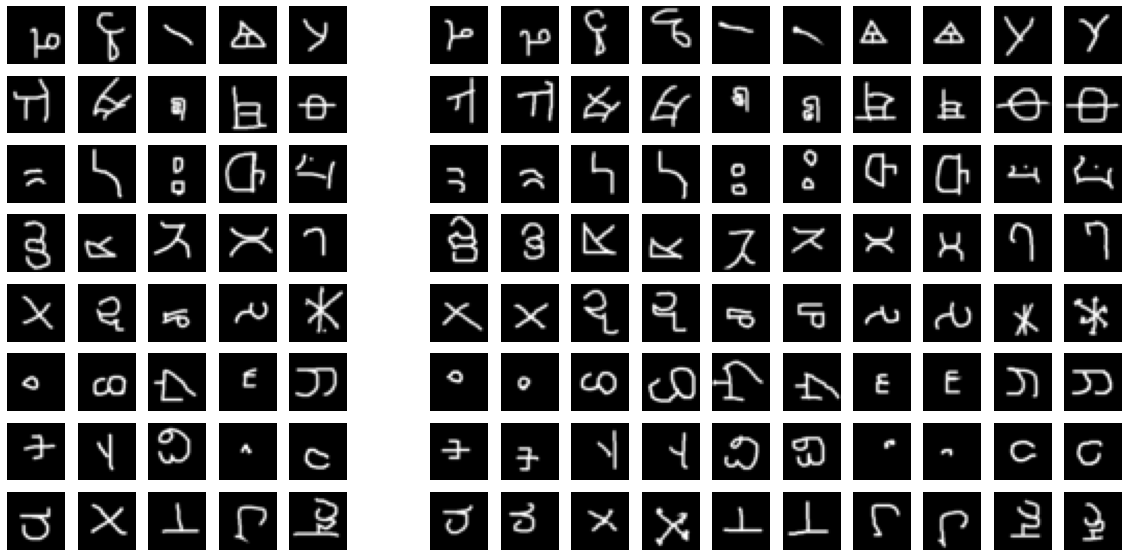

In [5]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=sample_cnt, ncols=image_per_sample+1, figsize=(20,10))
for batch in train_dataloader:
    for row in range(sample_cnt):
        for col in range(image_per_sample):
            tr_size = shots*ways
            if col<tr_size:
                cl = col
                pic = batch['train'][0][row][col].squeeze()
            else:
                axes[row, col].axis("off")
                cl = col + 1
                pic = batch['test'][0][row][col-tr_size].squeeze()
            axes[row, cl].axis("off")
            axes[row, cl].imshow(pic, cmap="gray")
    break
plt.show()

In [6]:
ways = 20
shots = 5
test_shots = 20 - shots
meta_batch_size = 8

train_dataset = omniglot(folder="./data", ways=ways, shots=shots, test_shots=test_shots, meta_train=True, download=True)
train_dataloader = BatchMetaDataLoader(train_dataset, batch_size=meta_batch_size, num_workers=4)

val_dataset = omniglot(folder="./data", ways=ways, shots=shots, test_shots=test_shots, meta_val=True, download=True)
val_dataloader = BatchMetaDataLoader(val_dataset, batch_size=meta_batch_size, num_workers=4, shuffle=False)

In [7]:
device = 'cuda:0'
fc_layer_size = 64
num_input_channels = 1
meta_lr = 1e-3

epochs = 50
batches_per_epoch = 512
val_batches_per_epoch = 64

meta_model = FewShotClassifier(num_input_channels, ways, fc_layer_size).to(device)
meta_optimiser = torch.optim.Adam(meta_model.parameters(), lr=meta_lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(meta_optimiser, epochs*batches_per_epoch)
loss_fn = nn.CrossEntropyLoss().to(device)

In [8]:

maml_order = 2

inner_train_steps = 1
inner_val_steps = 3
inner_lr = 0.4

for epoch in range(1, epochs + 1):
    correct1_train, total1_train = 0, 0
    with tqdm(train_dataloader, total=batches_per_epoch) as pbar:
        for batch_idx, batch in enumerate(pbar):
            loss, y_pred = meta_gradient_step(meta_model, meta_optimiser, loss_fn, batch, maml_order, inner_train_steps,
                                              inner_lr, train=True, device=device)
            
            y_true = batch["test"][1]
            correct1_train += torch.eq(y_pred.argmax(dim=-1).cpu(), y_true).sum().item()
            total1_train += y_true.numel()

            if batch_idx >= batches_per_epoch:
                break
    correct1_val, total1_val = 0, 0

    with tqdm(val_dataloader, total=val_batches_per_epoch) as pbar:
        for batch_idx, batch in enumerate(pbar):
            loss, y_pred = meta_gradient_step(meta_model, meta_optimiser, loss_fn, batch, maml_order, inner_val_steps,
                                              inner_lr, train=False, device=device)
            y_true = batch["test"][1]
            correct1_val += torch.eq(y_pred.argmax(dim=-1).cpu(), y_true).sum().item()
            total1_val += y_true.numel()

            if batch_idx >= val_batches_per_epoch:
                break
    print('[Epoch {}] Val accuracy: {:.2f}'.format(epoch, 100*correct1_val / total1_val))

  0%|          | 0/600 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:942: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:942: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:942: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:942: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


KeyboardInterrupt: 